In [2]:
import pandas as pd


In [3]:
df1 = pd.read_csv("~/Desktop/MSBA/SP/MGTA495b/hw2/blueprinty.csv")
df1.head()

,patents,region,age,iscustomer
0,0,Midwest,32.5,0
1,3,Southwest,37.5,0
2,4,Northwest,27.0,1
3,3,Northeast,24.5,0
4,3,Southwest,37.0,0


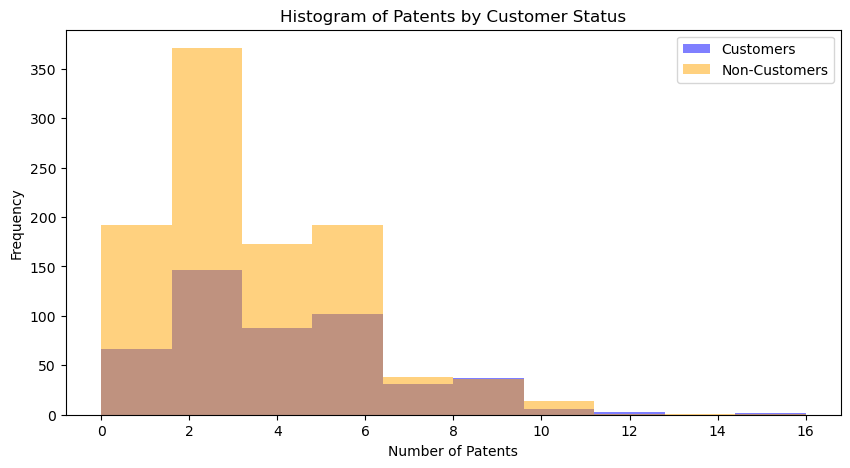

Mean number of patents for customers: 4.133056133056133
Mean number of patents for non-customers: 3.4730127576054954


In [4]:
import matplotlib.pyplot as plt

customers = df1[df1['iscustomer'] == 1]
non_customers = df1[df1['iscustomer'] == 0]

plt.figure(figsize=(10, 5))
plt.hist(customers['patents'], bins=10, alpha=0.5, label='Customers', color='blue')
plt.hist(non_customers['patents'], bins=10, alpha=0.5, label='Non-Customers', color='orange')
plt.xlabel('Number of Patents')
plt.ylabel('Frequency')
plt.title('Histogram of Patents by Customer Status')
plt.legend()
plt.show()

mean_customers = customers['patents'].mean()
mean_non_customers = non_customers['patents'].mean()

print(f"Mean number of patents for customers: {mean_customers}")
print(f"Mean number of patents for non-customers: {mean_non_customers}")

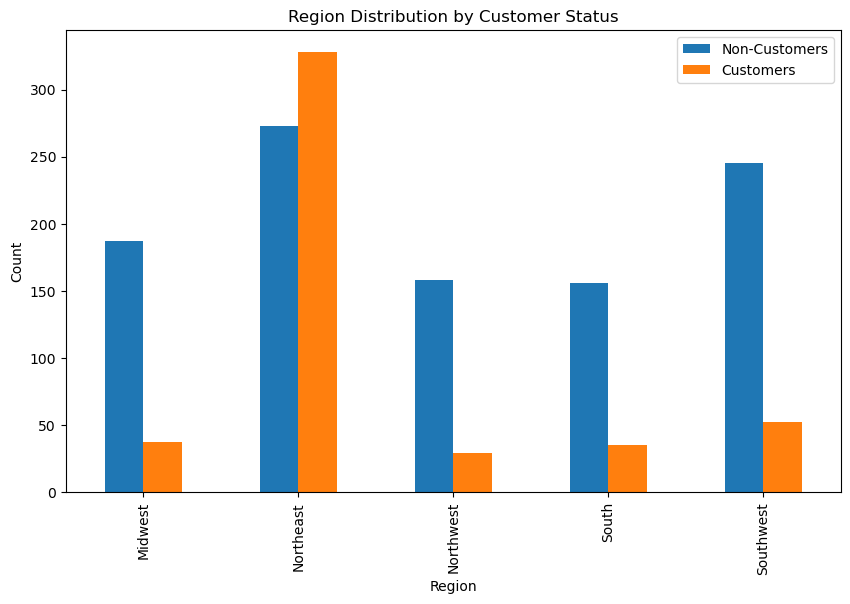

<Figure size 1000x600 with 0 Axes>

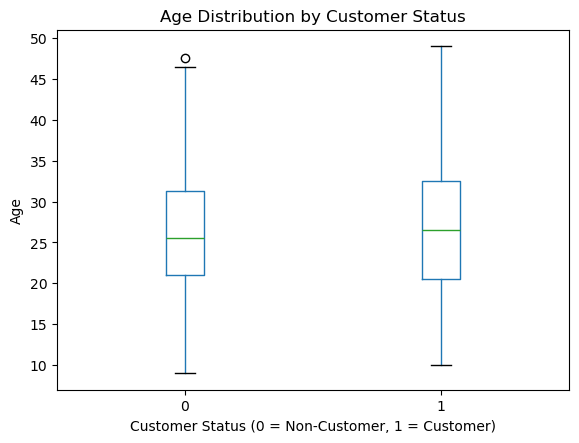

Mean age of patents for customers: 26.9002079002079
Mean age of patents for non-customers: 26.101570166830225


In [5]:
# Bar plot for region distribution by customer status
region_counts = df1.groupby(['region', 'iscustomer']).size().unstack()
region_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Region Distribution by Customer Status')
plt.xlabel('Region')
plt.ylabel('Count')
plt.legend(['Non-Customers', 'Customers'])
plt.show()

# Box plot for age distribution by customer status
plt.figure(figsize=(10, 6))
df1.boxplot(column='age', by='iscustomer', grid=False)
plt.title('Age Distribution by Customer Status')
plt.suptitle('')  
plt.xlabel('Customer Status (0 = Non-Customer, 1 = Customer)')
plt.ylabel('Age')
plt.show()

mean_age_customers = customers['age'].mean()
mean_age_non_customers = non_customers['age'].mean()

print(f"Mean age of patents for customers: {mean_age_customers}")
print(f"Mean age of patents for non-customers: {mean_age_non_customers}")

In [6]:
import numpy as np
from scipy.special import gammaln
from scipy.optimize import minimize_scalar

# Log-likelihood function for Poisson model
def poisson_loglikelihood(lambda_, Y):
    if lambda_ <= 0:
        return -np.inf  # return large negative value for invalid lambda
    ll = np.sum(-lambda_ + Y * np.log(lambda_) - gammaln(Y + 1))
    return ll

# Example: maximize using scipy
Y = np.array([2, 3, 1, 0, 4])  # example data

result = minimize_scalar(lambda l: -poisson_loglikelihood(l, Y), bounds=(0.001, 10), method='bounded')
print("Estimated lambda:", result.x)

Estimated lambda: 2.000000014292129


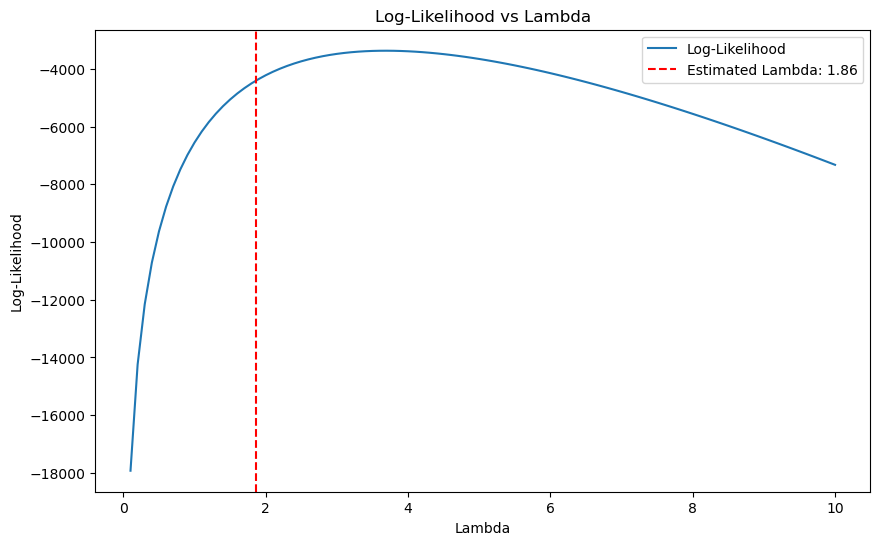

In [19]:
# Define a range of lambda values
lambda_values = np.linspace(0.1, 10, 100)

Y = df1['patents'].values  # Use the patents data from df1
# Compute the log-likelihood for each lambda
log_likelihoods = [poisson_loglikelihood(l, Y) for l in lambda_values]

# Plot the log-likelihood
plt.figure(figsize=(10, 6))
plt.plot(lambda_values, log_likelihoods, label='Log-Likelihood')
plt.xlabel('Lambda')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood vs Lambda')
plt.axvline(x=result.x, color='red', linestyle='--', label=f'Estimated Lambda: {result.x:.2f}')
plt.legend()
plt.show()

In [20]:
# Define the negative log-likelihood function
def neg_log_likelihood(lambda_):
    if lambda_ <= 0:
        return np.inf  
    ll = np.sum(-lambda_ + Y * np.log(lambda_) - gammaln(Y + 1))
    return -ll  # Negative because we minimize

# Find MLE using numerical optimization
result = minimize_scalar(neg_log_likelihood, bounds=(0.001, 100), method='bounded')
lambda_mle = result.x

# Compare with sample mean (Ȳ)
Y_bar = np.mean(Y)

# Print both
print(f"MLE for lambda (via optimization): {lambda_mle:.4f}")
print(f"Sample mean of Y (Ȳ): {Y_bar:.4f}")

MLE for lambda (via optimization): 3.6847
Sample mean of Y (Ȳ): 3.6847


In [36]:
def poisson_regression_loglikelihood(beta, Y, X):
    lambda_ = np.exp(X @ beta)
    if np.any(lambda_ <= 0):
        return np.inf
    ll = np.sum(-lambda_ + Y * np.log(lambda_) - gammaln(Y + 1))
    return -ll

In [41]:
import statsmodels.api as sm 
from scipy.optimize import minimize

# Ensure age_sq exists
df1['age_sq'] = df1['age'] ** 2

# Create dummy variables for region (drop first to avoid multicollinearity)
if 'region' in df1.columns:
    df1 = pd.get_dummies(df1, columns=['region'], drop_first=True)

# Define covariate columns in correct order
region_dummies = [col for col in df1.columns if col.startswith('region_') and col != 'region_Southwest']
X_cols = ['age', 'age_sq'] + region_dummies + ['iscustomer']

# Construct X matrix: constant first, then all covariates
X = df1[X_cols]
X.insert(0, 'Intercept', 1.0)  # Ensures first column is all 1's

# Convert to float (safe for optimization)
X = X.astype(float)

# Response variable
Y = df1['patents'].values

# Initial guess
beta_init = np.zeros(X.shape[1])

# Use BFGS method for optimization
result = minimize(poisson_regression_loglikelihood, beta_init, args=(Y, X), method='BFGS')

# Extract results
beta_hat = result.x
hessian = result.hess_inv
standard_errors = np.sqrt(np.diag(hessian))

# Output table
coef_table = pd.DataFrame({
    'Coefficient': beta_hat,
    'Std. Error': standard_errors
}, index=X.columns)

print(coef_table)


                  Coefficient  Std. Error
Intercept                 0.0         1.0
age                       0.0         1.0
age_sq                    0.0         1.0
region_Northeast          0.0         1.0
region_Northwest          0.0         1.0
region_South              0.0         1.0
iscustomer                0.0         1.0


/opt/conda/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/opt/conda/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/opt/conda/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [32]:
# Fit a Poisson regression model using sm.GLM
poisson_model = sm.GLM(Y, X, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# Display the summary of the results
print(poisson_results.summary())

# Compare coefficients from sm.GLM with your results
glm_coefficients = poisson_results.params
print("\nCoefficients from sm.GLM:")
print(glm_coefficients)

print("\nCoefficients from your optimization:")
print(beta_hat)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1492
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3258.1
Date:                Tue, 06 May 2025   Deviance:                       2143.3
Time:                        15:48:32   Pearson chi2:                 2.07e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1360
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.5089      0.183  

In [43]:
df = pd.read_csv("~/Desktop/MSBA/SP/MGTA495b/hw2/airbnb.csv")
df.head()

,Unnamed: 0,id,days,last_scraped,host_since,room_type,bathrooms,bedrooms,price,number_of_reviews,review_scores_cleanliness,review_scores_location,review_scores_value,instant_bookable
0,1,2515,3130,4/2/2017,9/6/2008,Private room,1.0,1.0,59,150,9.0,9.0,9.0,f
1,2,2595,3127,4/2/2017,9/9/2008,Entire home/apt,1.0,0.0,230,20,9.0,10.0,9.0,f
2,3,3647,3050,4/2/2017,11/25/2008,Private room,1.0,1.0,150,0,NaN,NaN,NaN,f
3,4,3831,3038,4/2/2017,12/7/2008,Entire home/apt,1.0,1.0,89,116,9.0,9.0,9.0,f
4,5,4611,3012,4/2/2017,1/2/2009,Private room,NaN,1.0,39,93,9.0,8.0,9.0,t


In [44]:
# Step 1: Data cleaning
vars_to_keep = [
    'number_of_reviews', 'days', 'room_type', 'bathrooms', 'bedrooms',
    'price', 'review_scores_cleanliness', 'review_scores_location',
    'review_scores_value', 'instant_bookable'
]
df = df[vars_to_keep].dropna()

# Step 2: Feature engineering
df['instant_bookable'] = (df['instant_bookable'] == 't').astype(int)
df = pd.get_dummies(df, columns=['room_type'], drop_first=True)

# Step 3: Build covariate matrix
X_cols = [
    'days', 'bathrooms', 'bedrooms', 'price',
    'review_scores_cleanliness', 'review_scores_location',
    'review_scores_value', 'instant_bookable'
] + [col for col in df.columns if col.startswith('room_type_')]

X = sm.add_constant(df[X_cols]).astype(float)
Y = df['number_of_reviews'].astype(int).values

# Step 4: Define Poisson log-likelihood
def poisson_loglikelihood(beta, Y, X):
    lambda_ = np.exp(X @ beta)
    if np.any(lambda_ <= 0):
        return np.inf
    ll = np.sum(-lambda_ + Y * np.log(lambda_) - gammaln(Y + 1))
    return -ll  # Negative log-likelihood for minimization

# Step 5: Fit model
beta_init = np.zeros(X.shape[1])
result = minimize(poisson_loglikelihood, beta_init, args=(Y, X), method='BFGS')

# Step 6: Extract results
beta_hat = result.x
hessian = result.hess_inv
standard_errors = np.sqrt(np.diag(hessian))

# Step 7: Display coefficient table
coef_table = pd.DataFrame({
    'Coefficient': beta_hat,
    'Std. Error': standard_errors
}, index=X.columns)

print(coef_table)

                           Coefficient  Std. Error
const                              0.0         1.0
days                               0.0         1.0
bathrooms                          0.0         1.0
bedrooms                           0.0         1.0
price                              0.0         1.0
review_scores_cleanliness          0.0         1.0
review_scores_location             0.0         1.0
review_scores_value                0.0         1.0
instant_bookable                   0.0         1.0
room_type_Private room             0.0         1.0
room_type_Shared room              0.0         1.0


/opt/conda/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/opt/conda/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/opt/conda/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.12/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
